In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch


In [2]:
data = pd.read_csv('./bot.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','category','state','proto','seq'],inplace=True)

In [4]:
data.rename(columns={"attack": "label"},inplace = True)

In [5]:
data.label.value_counts()

1    3668045
0        477
Name: label, dtype: int64

In [6]:
#le = LabelEncoder()
#le.fit_transform(data.label.values)
#data['label'] = le.transform(data['label'])

In [7]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [8]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [9]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [10]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [11]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [12]:
data.fillna(0,inplace = True)

In [13]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [14]:
data.drop(columns=['index'],inplace=True)

In [15]:
data

,saddr,daddr,pkts,bytes,ltime,dur,mean,stddev,sum,min,...,state_number_7,state_number_8,state_number_9,state_number_10,state_number_11,proto_number_1,proto_number_2,proto_number_3,proto_number_4,proto_number_5
0,172.22.188.85:49960,192.168.100.7:80,8,1980,1.528089e+09,7.056393,0.068909,0.068909,0.137818,0.000000,...,0,0,0,0,0,1,0,0,0,0
1,172.21.178.69:-1,192.168.100.147:-1,2,120,1.528089e+09,0.000131,0.000131,0.000000,0.000131,0.000131,...,0,0,0,0,0,0,1,0,0,0
2,172.24.211.173:49962,192.168.100.7:80,8,2126,1.528089e+09,7.047852,0.064494,0.064494,0.128988,0.000000,...,0,0,0,0,0,1,0,0,0,0
3,172.18.145.65:49964,192.168.100.7:80,8,2024,1.528089e+09,7.047592,0.064189,0.064189,0.128378,0.000000,...,0,0,0,0,0,1,0,0,0,0
4,172.30.55.23:49966,192.168.100.7:80,8,2319,1.528089e+09,7.046841,0.063887,0.063887,0.127774,0.000000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3668517,172.29.73.1:35064,192.168.100.3:22,6,434,1.529381e+09,0.013165,0.013165,0.000000,0.013165,0.013165,...,0,0,0,0,0,1,0,0,0,0
3668518,172.24.28.79:35066,192.168.100.3:22,6,434,1.529381e+09,0.000574,0.000574,0.000000,0.000574,0.000574,...,0,0,0,0,0,1,0,0,0,0
3668519,172.26.187.152:35070,192.168.100.3:22,31,5472,1.529381e+09,2.874302,2.874302,0.000000,2.874302,2.874302,...,0,0,0,0,0,1,0,0,0,0
3668520,172.27.238.214:43001,192.168.100.150:4433,2,134,1.529381e+09,0.000003,0.000003,0.000000,0.000003,0.000003,...,0,0,0,0,0,1,0,0,0,0


In [16]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 2:].columns ))  - set(list(['label'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [18]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

<ipython-input-18-841b8327893c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [19]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [20]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [21]:
G = G.to_directed()

In [22]:
G = from_networkx(G,edge_attrs=['h','label'])

In [23]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [24]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [25]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [26]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [29]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [30]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [31]:
G.ndata['h'].shape

torch.Size([2581116, 1, 55])

In [32]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [33]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [34]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [35]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

In [36]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [37]:
G = G.to('cuda:0')

In [38]:
G.device

device(type='cuda', index=0)

In [39]:
G.ndata['h'].device  

device(type='cuda', index=0)

In [40]:
G.edata['h'].device  

device(type='cuda', index=0)

In [41]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,700):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.9999405741691589
Epoch: 200  Training acc: 0.9999445080757141
Epoch: 300  Training acc: 0.999947190284729
Epoch: 400  Training acc: 0.9999446868896484
Epoch: 500  Training acc: 0.9999499320983887
Epoch: 600  Training acc: 0.9999452829360962


In [67]:
model.load_state_dict(th.load('model.pt'))
model.eval()

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_apply): Linear(in_features=110, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_apply): Linear(in_features=183, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [42]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

<ipython-input-42-84be06ca8888>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['h'] = X_test[ cols_to_norm ].values.tolist()


In [43]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 55)

In [44]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [45]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [46]:
G_test = G_test.to('cuda:0')

In [47]:
th.cuda.empty_cache()

In [68]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [69]:
print(str(elapsed) + ' seconds')

0.26155815399943094 seconds


In [70]:
test_pred = test_pred.argmax(1)

In [71]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [72]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [73]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

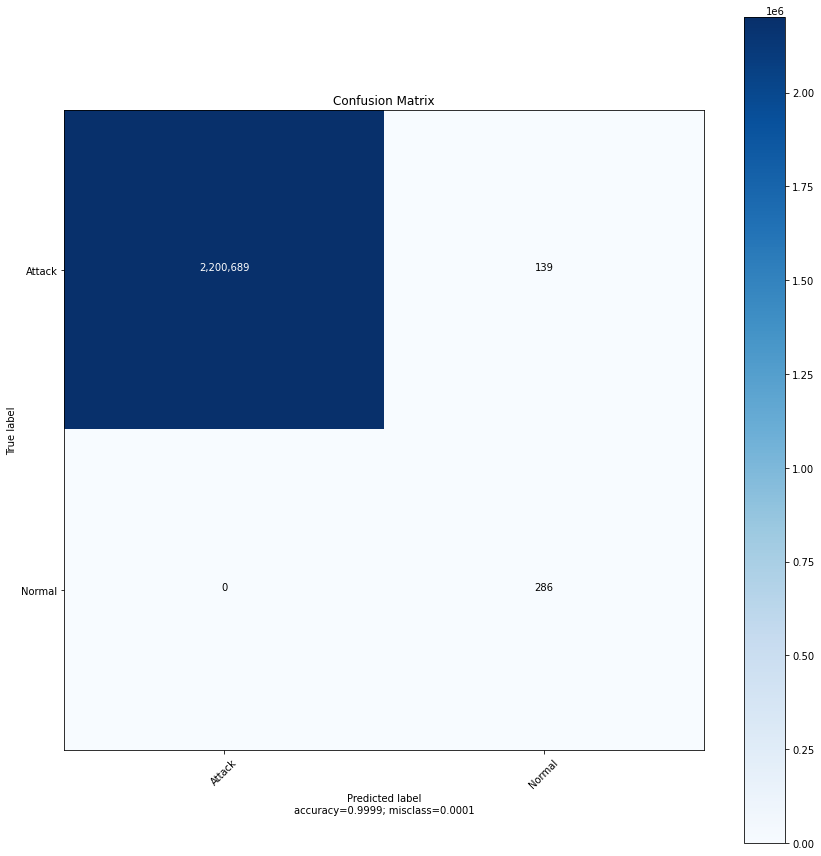

In [74]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")